In [611]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import string
import time
import matplotlib.pyplot as plt

In [612]:
#initializes our dataframes
columns = ['Country','code','Year','BPD']
df= pd.DataFrame(columns=columns)
da = pd.DataFrame(columns = ['Country','Code'])
dall = pd.DataFrame(columns=columns)

In [613]:
#get's a representative page
page = requests.get('https://www.indexmundi.com/energy/?country=al&product=gasoline&graph=consumption')
soup = BeautifulSoup(page.content, 'html.parser')


In [614]:
#finds all the country codes
tb = soup.find('table',id="gvCountries") #get table with countries
for i,ln in enumerate(tb.select('a[href^="?country"]')): #find the line we care about
    ctry = ln.text
    ln = ln.get('href').split('=')[1].split('&')[0]
    da.loc[i] = [ctry,ln]

In [608]:
can = da.Country == 'Canada'

In [616]:
#Loops through all the countries and grabs the Thousands of barrels per day consumption data for each year
for country,code in zip(da.Country,da.Code):
    time.sleep(0.5)
    page = requests.get('https://www.indexmundi.com/energy/?country=' + code + '&product=gasoline&graph=consumption')
    soup = BeautifulSoup(page.content, 'html.parser')
    
    for i,ln in enumerate(soup.find_all('tr',align='right')):
        year=list(ln.children)[1].text
        BPD = list(ln.children)[2].text.replace(",","")
        df.loc[i] = [country,code,int(float(year)),float(BPD)]
    dall = dall.append(df) #appends in stacked form
    #print(dall)

In [615]:
dall

,Country,code,Year,BPD


In [653]:
#Pivot our table.  ds
dw = dall.pivot_table(
        values='BPD', 
        index=['Country', 'code'], 
        columns='Year', )

In [654]:
dw.to_csv('GasConsumption.csv')

In [632]:
#Loads the GasCost and GasConsumption (was made by data scraping)
Cost = pd.read_csv("GasCost.csv", encoding = "ISO-8859-1")
Con = pd.read_csv("GasConsumption.csv", encoding = "ISO-8859-1")
MHI = pd.read_csv("MHI.csv", encoding = "ISO-8859-1")
Pop = pd.read_csv("Population.csv", encoding = "ISO-8859-1")

In [633]:
#Bring all the files into a stacked form
Con_a = pd.melt(Con, 
            id_vars='Country', 
            value_vars=list(Con.columns[2:]), # list of days of the week
            var_name='Year', 
            value_name='BPD')
Cost_a = pd.melt(Cost, 
            id_vars='Country', 
            value_vars=list(Cost.columns[2:]), # list of days of the week
            var_name='Year', 
            value_name='Cost')
MHI_a = pd.melt(MHI, 
            id_vars='Country Name', 
            value_vars=list(MHI.columns[2:]), # list of days of the week
            var_name='Year', 
            value_name='MHI')
MHI_a.columns = ['Country','Year','MHI']
Pop_a = pd.melt(Pop, 
            id_vars='Country Name', 
            value_vars=list(Pop.columns[2:]), # list of days of the week
            var_name='Year', 
            value_name='Pop')
Pop_a.columns = ['Country','Year','Pop']

In [634]:
dm = pd.merge(left=Con_a,right=Cost_a, left_on=['Country','Year'], right_on=['Country','Year'])
dm = pd.merge(left=dm,right=MHI_a, left_on=['Country','Year'], right_on=['Country','Year'])
dm = pd.merge(left=dm,right=Pop_a, left_on=['Country','Year'], right_on=['Country','Year'])

In [670]:
#finalize fields and convert to the same label that david uses.

dm['Affordability'] = dm.MHI/dm.Cost
dm['NBPD']=dm.BPD/dm.Pop
dm['DPL']=dm.Cost
dm.Year = dm.Year.astype('int64')
g1 = dm

In [677]:
g1r = g1.reset_index()
g1r['NDPL'] = g1.DPL/(g1.MHI/365.0)
g1['NBPD'] = g1.BPD*1000/g1.Pop
mk = g1r.Year == 2012
richmask = g1r.MHI>33000
richmask2012 = g1r.MHI[mk]>33000
richcountries = g1r[mk][richmask2012].Country.unique()
richmask2012 = g1r.Country.isin(richcountries)

In [681]:
#Load in davids csv so I don't have to do the unit conversions and stuff myself
g1 = pd.read_csv('GasData.csv')
g1r = g1.reset_index()
mk = g1r.Year == 2012
richmask = g1r.MHI>33000
richmask2012 = g1r.MHI[mk]>33000
richcountries = g1r[mk][richmask2012].Country.unique()
richmask2012 = g1r.Country.isin(richcountries)

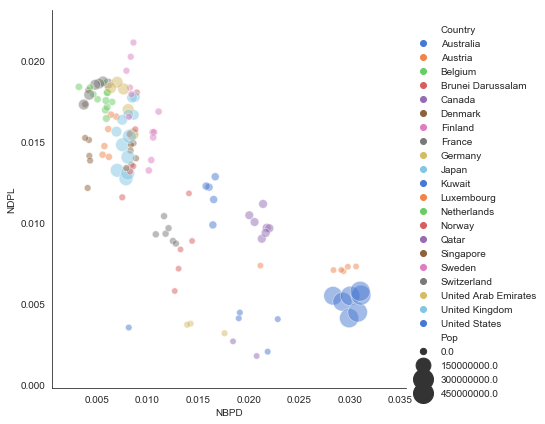

In [682]:
AsiaOceana = ['Australia','Japan','New Zealand','Singapore']
GulfState = ['Brunei Darussalam','Kuwait','Qatar','United Arab Emirates']
USA = ['United States']
Canada = ['Canada']
Europe = ['Austria', 'Belgium',\
 'Denmark','Finland','France','Germany','Iceland','Ireland',\
'Luxembourg','Netherlands','Norway',\
 'Sweden','Switzerland',\
 'United Kingdom']

Regions = {'AsiaOceana':AsiaOceana,'GulfState':GulfState,'USA':USA,\
          'Canada':Canada,'Europe':Europe}

Regions = {'AsiaOceana':AsiaOceana,'USA':USA,\
          'Canada':Canada,'Europe':Europe}


cols = sns.color_palette('deep',len(Regions))

sns.relplot(x="NBPD", y="NDPL", hue="Country", size="Pop",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=g1r[richmask2012&remask])

Text(0.5, 0, 'Higher is More Expensive')

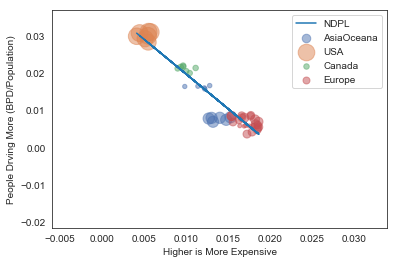

In [686]:
largemask = g1r[richmask2012&remask].Pop>(15*10**6)

for (i,c) in zip(Regions.keys(),cols):
    regionmask = g1r[richmask2012&remask&largemask].Country.isin(Regions[i])
    plt.scatter(g1r[richmask2012&remask&regionmask&largemask].NDPL,g1r[richmask2012&remask&regionmask&largemask].NBPD,\
              s=g1r[richmask2012&remask&regionmask&largemask].Pop/10**6,alpha = .5,marker = 'o',color = c,label = i)
    
x = g1r[richmask2012&remask&largemask].NDPL
y = g1r[richmask2012&remask&largemask].NBPD
df = pd.DataFrame({'NDPL':x,'NBPD':y})
from lmfit.models import LinearModel
mod = LinearModel()
res = mod.fit(y,x=x, nan_policy='drop')
y = mod.eval(x=x, params = res.params)
plt.plot(x,y)
plt.legend()
#plt.xlim(0,.00008)
#plt.ylim(0,.00004)
#plt.yticks([])
#plt.xticks([])
plt.ylabel('People Drving More (BPD/Population)')
plt.xlabel('Higher is More Expensive')

In [651]:
mk = dm.Year == 2012
mr = dm.MHI > 20000
richmask=mr
mUSA = dm.Country == 'United States'
mGermany = dm.Country == 'Germany'
can = dm.Country == 'Canada'
g1r = dm
richmask2012 = g1r.MHI[mk] > 33000

,Country,Year,BPD,Cost,MHI,Pop,Affordability,NBPD,DPL
0,Afghanistan,1991,2.5,NaN,NaN,12993657.0,NaN,1.924016e-07,NaN
1,Albania,1991,1.9,NaN,290.300641,3266790.0,NaN,5.816107e-07,NaN
2,Algeria,1991,48.0,0.15,1421.799715,26554329.0,9478.664767,1.807615e-06,0.15
3,American Samoa,1991,0.4,NaN,NaN,48375.0,NaN,8.268734e-06,NaN
4,Angola,1991,1.6,NaN,461.844262,12553446.0,NaN,1.274550e-07,NaN
5,Antigua and Barbuda,1991,0.5,NaN,NaN,67307.0,NaN,7.428648e-06,NaN
6,Argentina,1991,102.0,NaN,5082.627516,33193918.0,NaN,3.072852e-06,NaN
7,Armenia,1991,NaN,NaN,NaN,3505251.0,NaN,NaN,NaN
8,Aruba,1991,0.7,NaN,NaN,64622.0,NaN,1.083222e-05,NaN
9,Australia,1991,290.0,NaN,14677.236130,17284000.0,NaN,1.677852e-05,NaN


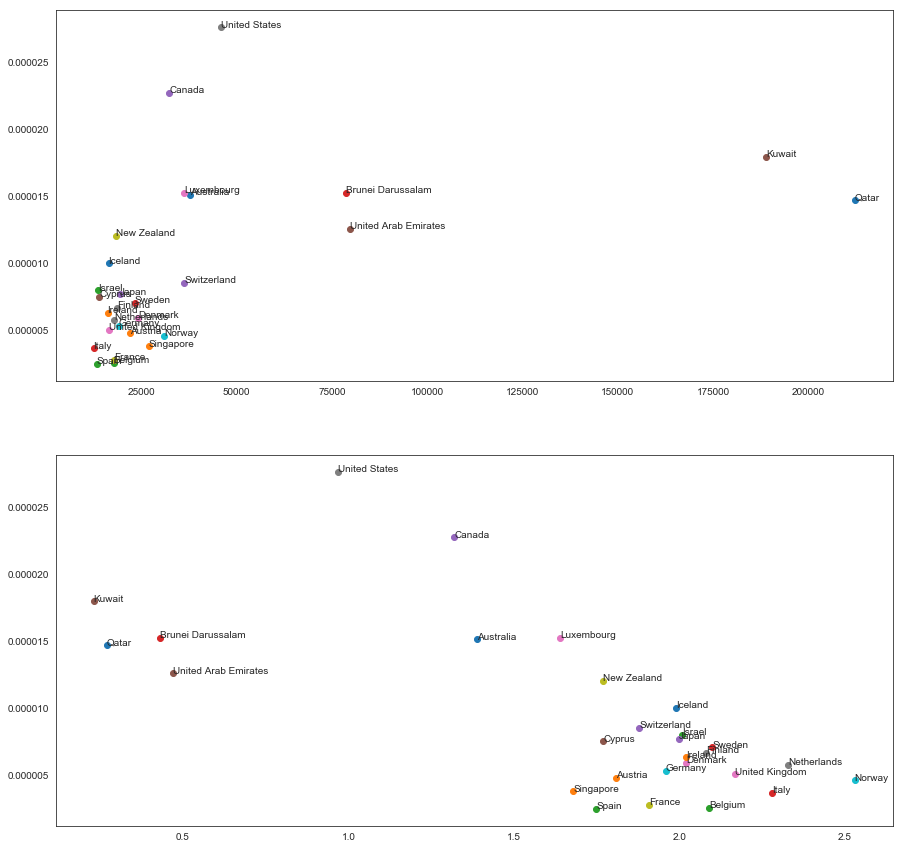

In [639]:
#plt.plot(dm[mk&mr].Cost,dm[mk&mr].NBPD,marker = 'o',ls = '')
fig,ax = plt.subplots(figsize = (15,15),nrows=2)
for (afor,dpl,nbpd,con) in zip(g1r[mk&richmask].Affordability,g1r[mk&richmask].DPL,g1r[mk&richmask].NBPD,g1r[mk&richmask].Country):
    ax[0].plot(afor,nbpd,marker = 'o',ls = '',label = con)
    ax[0].annotate(con,(afor,nbpd))
    ax[1].plot(dpl,nbpd,marker = 'o',ls = '',label = con)
    ax[1].annotate(con,(dpl,nbpd))    
#ax.legend()

In [571]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("white")
import pandas as pd
import math
my_dpi=96

<Figure size 680x480 with 0 Axes>

<Figure size 680x480 with 0 Axes>

<Figure size 680x480 with 0 Axes>

<Figure size 680x480 with 0 Axes>

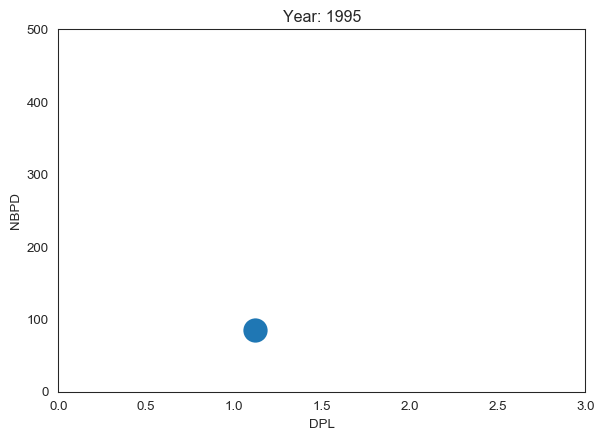

<Figure size 680x480 with 0 Axes>

<Figure size 680x480 with 0 Axes>

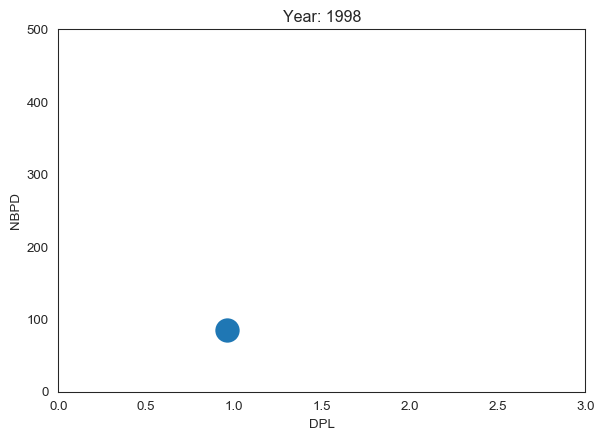

<Figure size 680x480 with 0 Axes>

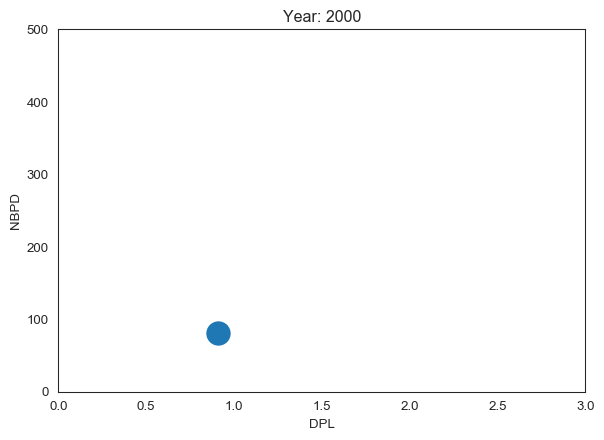

<Figure size 680x480 with 0 Axes>

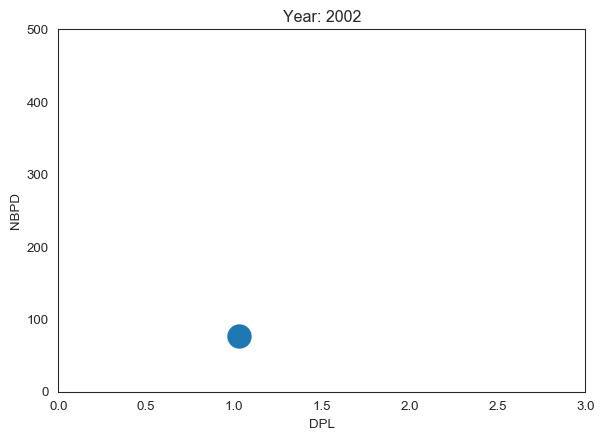

<Figure size 680x480 with 0 Axes>

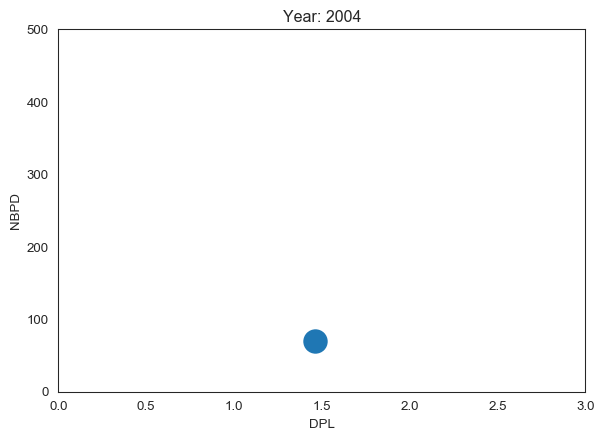

<Figure size 680x480 with 0 Axes>

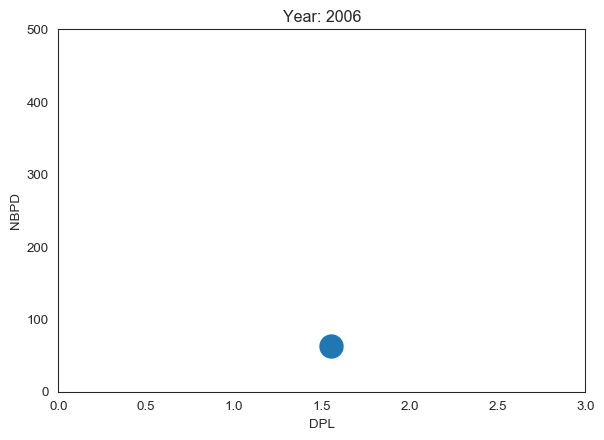

<Figure size 680x480 with 0 Axes>

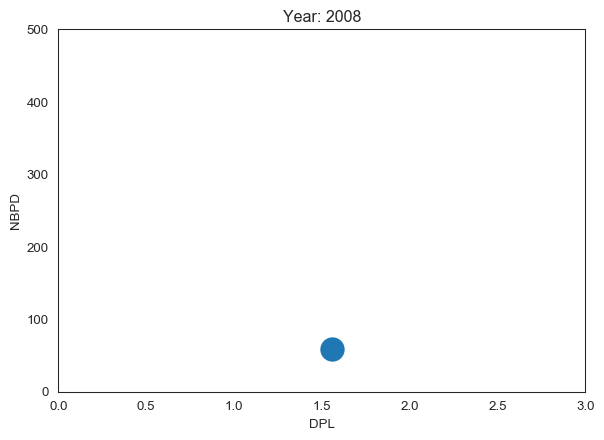

<Figure size 680x480 with 0 Axes>

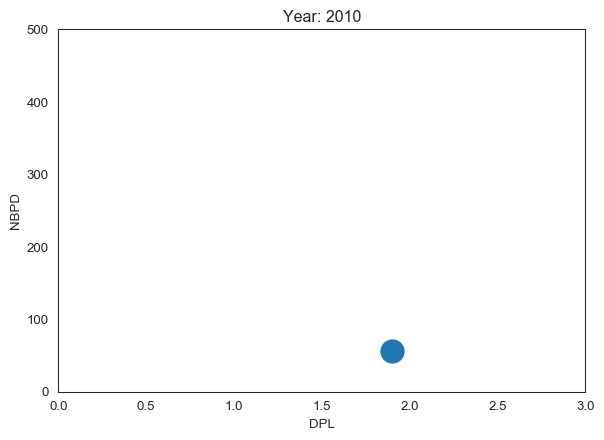

<Figure size 680x480 with 0 Axes>

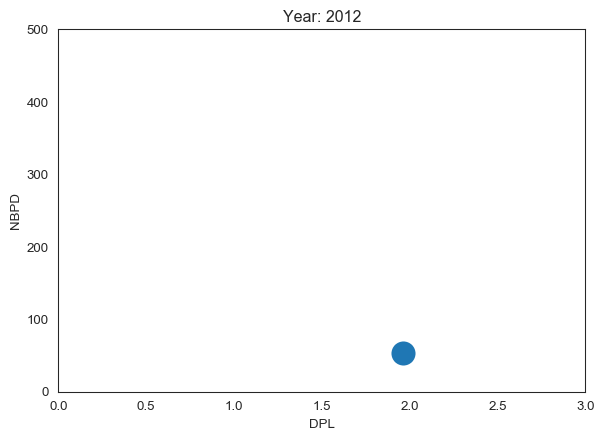

In [606]:
data = dm[mGermany]
# For each year:
for i in data.Year.unique():

    # initialize a figure
    fig = plt.figure(figsize=(680/my_dpi, 480/my_dpi), dpi=my_dpi)

    # Change color with c and alpha. I map the color to the X axis value.
    tmp = data[ data.Year == i]
    if not math.isnan(tmp['DPL']/tmp['NBPD']):
        plt.scatter(tmp['DPL'], tmp['NBPD']*10**7 , s=tmp['Pop']/200000 , edgecolors="white", linewidth=2)

        # Add titles (main and on axis)
        #plt.yscale('log')
        plt.xlabel("DPL")
        plt.ylabel("NBPD")
        plt.title("Year: "+str(i) )
        plt.ylim(0,500)
        plt.xlim(0, 3)

        # Save it
        filename='Gapminder_step'+str(i)+'.png'
        plt.savefig(filename, dpi=96)
        plt.gca()

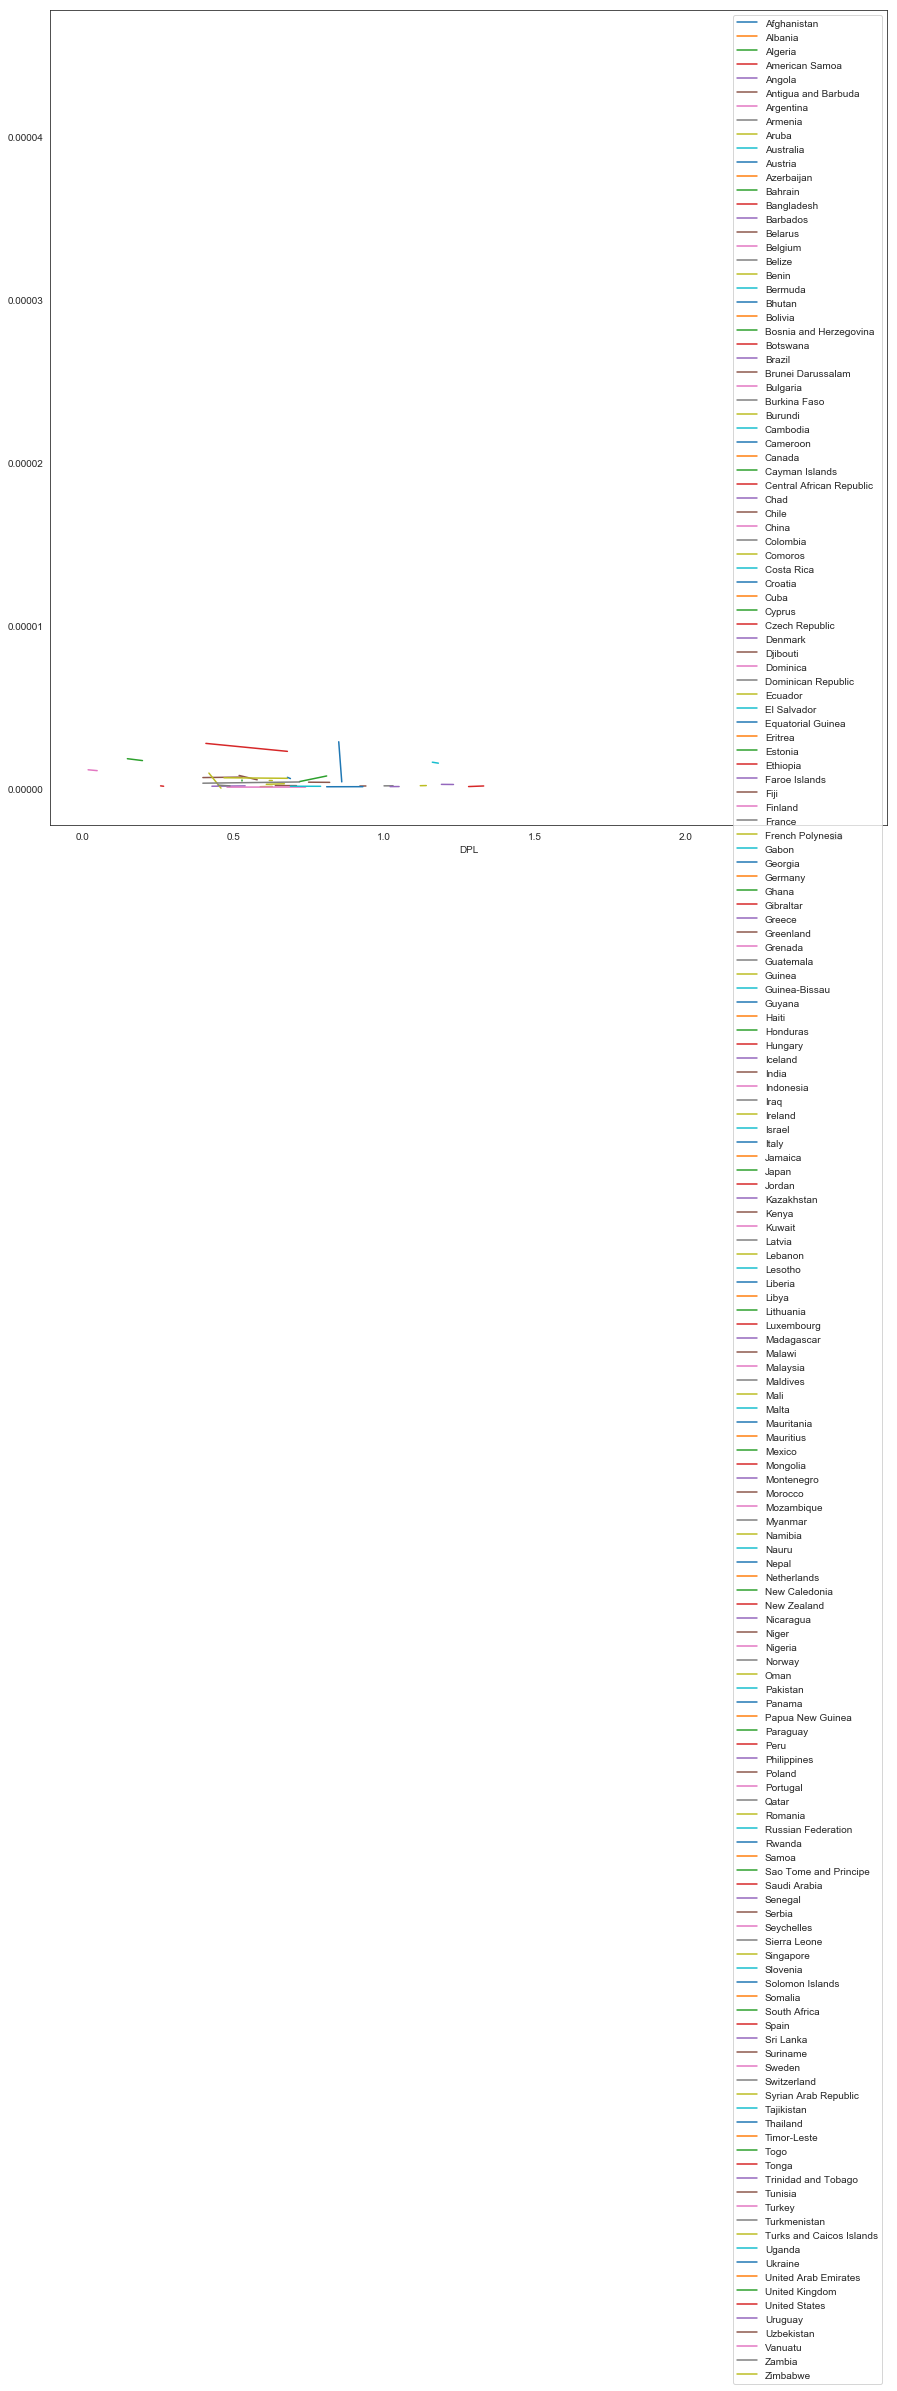

In [605]:

dm['Country']=pd.Categorical(dm['Country'])

fig, ax = plt.subplots(figsize = (15,15))
for key, grp in dm.groupby(['Country']):
    ax = grp.plot(ax=ax, x='DPL', y='NBPD', label=key)
plt.show()

In [652]:
remask = g1r.Year>1990
ax = sns.lineplot(x="Year", y="BPD",
            hue="Country",
            data=g1r[richmask2012][remask])
ax.axvline(2008)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [ ]:
AsiaOceana = ['Australia','Japan','New Zealand','Singapore']
GulfState = ['Brunei Darussalam','Kuwait','Qatar','United Arab Emirates']
USA = ['United States']
Canada = ['Canada']
Europe = ['Austria', 'Belgium',\
'Denmark','Finland','France','Germany','Iceland','Ireland',\
'Luxembourg','Netherlands','Norway',\
'Sweden','Switzerland',\
'United Kingdom']

Regions = {'AsiaOceana':AsiaOceana,'GulfState':GulfState,'USA':USA,\
         'Canada':Canada,'Europe':Europe}
cols = sns.color_palette('deep',len(Regions))

sns.relplot(x="NBPD", y="NDPL", hue="Country", size="Pop",
           sizes=(40, 400), alpha=.5, palette="muted",
           height=6, data=g1r[richmask2012&remask])

In [685]:
!pip install lmfit

  Running setup.py bdist_wheel for lmfit: started
  Running setup.py bdist_wheel for lmfit: finished with status 'done'
  Stored in directory: C:\Users\jsmit\AppData\Local\pip\Cache\wheels\97\fd\8b\fb5d58fac3172d7408c938f7678ff477e3d2913a4ec7d95bcc
  Running setup.py bdist_wheel for asteval: started
  Running setup.py bdist_wheel for asteval: finished with status 'done'
  Stored in directory: C:\Users\jsmit\AppData\Local\pip\Cache\wheels\f8\04\bf\0bae97344b951ec270d12cf6c0ee6565433631aa4d95979b5b
  Running setup.py bdist_wheel for uncertainties: started
  Running setup.py bdist_wheel for uncertainties: finished with status 'done'
  Stored in directory: C:\Users\jsmit\AppData\Local\pip\Cache\wheels\21\59\34\ec5b91498ae18a36d995b845081f288d5ea972374ae8a779ed
Successfully built lmfit asteval uncertainties


In [689]:
'{:.2e}'.format(17815*127586000)

'2.27e+12'